# Исследование заведений общественного питания Москвы

Инвесторов интересует текущее положение дел на рынке заведений общественного питания — сможет ли новое кафе, где гостей должны обслуживать роботы, снискать популярность на долгое время. Необходимо подготовить исследование рынка.

В нашем распоряжении есть открытые данные о заведениях общественного питания в Москве.

**Цель исследования**:
* Сделать вывод и дать рекомендации о виде заведения, количестве посадочных мест, а также районе расположения. Прокомментировать возможность развития сети;
* Подготовить презентацию исследования для инвесторов.

**Оглавление проекта**
1. [Изучение данных и подготовка их к анализу](#start)
    * 1.1. [Предобработка данных](#preprocessing)
    * 1.2. [Вывод по данным](#conclusion_1)
2. [Анализ данных](#analysis)
    * 2.1. [Cоотношение видов объектов общественного питания по количеству](#analysis_1)
    * 2.2. [Cоотношение сетевых и несетевых заведений по количеству](#analysis_2)
    * 2.3. [Вывод по объектам питания с сетевым распространением](#analysis_3)
    * 2.4. [Что характерно для сетевых заведений](#analysis_4)
    * 2.5. [Cреднее количество посадочных мест для каждого вида объекта питания](#analysis_5)
    * 2.6. [Выделение улицы у объектов](#analysis_6)
    * 2.7. [Топ-10 улиц по количеству объектов общественного питания](#analysis_7)
    * 2.8. [Улицы с одним объектом общественного питания](#analysis_8)
    * 2.9. [Распределение количества посадочных мест для улиц с большим количеством объектов](#analysis_9)
3. [Общий вывод и рекомендации](#conclusion)
4. [Презентация по исследованию](#preza)

## Изучение данных и подготовка их к анализу
<a id="start"></a>
Импортируем нужные библиотеки, загрузим данные, преобразуем значения в столбцах при необходимости, проверим на дубликаты.

In [1]:
# импорт необходимых библиотек
import pandas as pd
pd.set_option('display.float_format', '{:,.2f}'.format)
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly import graph_objects as go
import warnings
warnings.filterwarnings('ignore')
from io import BytesIO
import requests

In [2]:
# загрузка данных с возможностью открывать файл локально
path = 'C:/Data/'
data = pd.read_csv(path + 'rest_data.csv')

# знакомство с данными
display(data)
data.info()

id             object_name chain object_type  \
0      151635                 СМЕТАНА   нет        кафе   
1       77874                  Родник   нет        кафе   
2       24309         Кафе «Академия»   нет        кафе   
3       21894              ПИЦЦЕТОРИЯ    да        кафе   
4      119365  Кафе «Вишневая метель»   нет        кафе   
...       ...                     ...   ...         ...   
15361  208537             Шоколадница    да        кафе   
15362  209264             Шоколадница    да        кафе   
15363  209186             Шоколадница    да        кафе   
15364  221900             Шоколадница    да        кафе   
15365  222535             Шоколадница    да        кафе   

                                                 address  number  
0             город Москва, улица Егора Абакумова, дом 9      48  
1      город Москва, улица Талалихина, дом 2/1, корпус 1      35  
2              город Москва, Абельмановская улица, дом 6      95  
3                город Москва, Абрамцевская улица, дом 1      40  
4      город Москва, Абрамцевская улица, дом 9, корпус 1      50  
...                                                  ...     ...  
15361       город Москва, 3-й Крутицкий переулок, дом 18      50  
15362           город Москва, улица Земляной Вал, дом 33      10  
15363           город Москва, улица Земляной Вал, дом 33      20  
15364  город Москва, поселение Московский, Киевское ш...      36  
15365             город Москва, Ходынский бульвар, дом 4      10  

[15366 rows x 6 columns]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
id             15366 non-null int64
object_name    15366 non-null object
chain          15366 non-null object
object_type    15366 non-null object
address        15366 non-null object
number         15366 non-null int64
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


In [3]:
# вывод описательной статистики
data.describe(include='all').T

count unique                                     top   freq  \
id          15,366.00    NaN                                     NaN    NaN   
object_name     15366  10393                                Столовая    267   
chain           15366      2                                     нет  12398   
object_type     15366      9                                    кафе   6099   
address         15366   9108  город Москва, Ходынский бульвар, дом 4     95   
number      15,366.00    NaN                                     NaN    NaN   

                  mean       std    min       25%        50%        75%  \
id          119,720.07 73,036.13 838.00 28,524.00 144,974.50 184,262.25   
object_name        NaN       NaN    NaN       NaN        NaN        NaN   
chain              NaN       NaN    NaN       NaN        NaN        NaN   
object_type        NaN       NaN    NaN       NaN        NaN        NaN   
address            NaN       NaN    NaN       NaN        NaN        NaN   
number           59.55     74.74   0.00     12.00      40.00      80.00   

                   max  
id          223,439.00  
object_name        NaN  
chain              NaN  
object_type        NaN  
address            NaN  
number        1,700.00

### Предобработка данных
<a id="preprocessing"></a>
Проверять таблицу на явные дубликаты смысла нет, так как имеются уникальные id в каждой строке. Проверяем таблицу`object_type` на неявные дубликаты:

In [4]:
data['object_type'].unique()

array(['кафе', 'столовая', 'закусочная',
       'предприятие быстрого обслуживания', 'ресторан', 'кафетерий',
       'буфет', 'бар', 'магазин (отдел кулинарии)'], dtype=object)

Проверяем столбец `object_name` на неявные дубликаты:

In [5]:
data['object_name'].value_counts().head(50)

Столовая                                267
Кафе                                    236
Шаурма                                  234
KFC                                     155
Шоколадница                             142
Макдоналдс                              122
Бургер Кинг                             122
Домино'с Пицца                           86
Теремок                                  84
Крошка Картошка                          82
Пекарня                                  76
Милти                                    65
Суши Wok                                 61
Буфет                                    59
СТОЛОВАЯ                                 52
Папа Джонс                               50
Школьно-базовая столовая                 44
Кофе с собой                             44
Чайхона №1                               42
КАФЕ                                     41
Выпечка                                  36
Хинкальная                               35
Кафетерий                       

Видно множество синонимов, попробуем привести все к нижнему регистру:

In [6]:
data['object_name'] = data['object_name'].str.lower()

С помощью словаря синонимов обработаем по возможности различные вариации известных кафе и ресторанов:

In [7]:
synonyms = {"mcDonald's":['макдоналдс', 'ресторан «макдоналдс»', 'кафе «макдоналдс»'],
            "starbucks":['старбакс', 'кафе «старбакс»', 'кофейня «старбакс»', 'кафе «starbucks»'],
            "burger king":['бургер кинг', 'ресторан «бургер кинг»', 'ресторан «burger king»', 'кафе «бургер кинг»'],
            "kfc":['кфц', 'ресторан «kfc»', 'ресторан «кфц»'],
            "суши wok":['кафе «суши wok»', 'кафе «суши вок»', 'суши вок'],
            "papa john’s":['папа джонс', 'пиццерия «папа джонс»'],
            "domino’s pizza":["домино'с пицца", "пиццерия «домино'с пицца»"],
            "pizza hut":['пицца хат', 'пиццерия «пицца хат»'],
            "il patio":['иль патио', 'ресторан «иль патио»'],            
            "subway":['сабвей', 'ресторан «сабвей»'],
            "якитория":['ресторан «якитория»', 'кафе «якитория»'],
            "тануки":['ресторан «тануки»', 'кафе «тануки»'],
            "му-му":['кафе «му-му»', 'ресторан «му-му»'],
            "шоколадница":['кафе «шоколадница»', 'кофейня «шоколадница»'],
            "кофе хаус":['кафе «кофе хаус»', 'кофейня «кофе хаус»'],
            "кулинарная лавка братьев караваевых":['кафе «кулинарная лавка братьев караваевых»']}
# объявляем функцию проверки и замены синонимов:
def check_synonyms(cell):
    for name, syn in synonyms.items():
        if cell in syn: return name
    return cell

data['object_name'] = data['object_name'].apply(check_synonyms)

Хотя явных дубликатов и нет, но в выводе таблицы заметно, что есть кафе с одним и тем же адресом и названием (например, с индексом 15362 и 15363). Попробуем найти дубликаты по всем столбцам кроме `id`:

In [8]:
data[data.duplicated(subset=['object_name', 'chain', 'address', 'object_type', 'number'],
                     keep = False)].sort_values(by = list(data.columns)) # keep = False выведет все совпадения

id              object_name chain  \
6420    19756                      бар   нет   
6423    19759                      бар   нет   
3396    19814  буфет «коникс-школьник»   нет   
5058    20019                     lift   нет   
5059    20021                     lift   нет   
...       ...                      ...   ...   
14309  221133                     кафе   нет   
14119  222452                   шаурма   нет   
14118  222458                   шаурма   нет   
14577  222885              старый баку   нет   
14578  222932              старый баку   нет   

                             object_type  \
6420                                 бар   
6423                                 бар   
3396                               буфет   
5058                                кафе   
5059                                кафе   
...                                  ...   
14309                               кафе   
14119  предприятие быстрого обслуживания   
14118  предприятие быстрого обслуживания   
14577                               кафе   
14578                               кафе   

                                                 address  number  
6420   город Москва, улица Улофа Пальме, дом 5, строе...      10  
6423   город Москва, улица Улофа Пальме, дом 5, строе...      10  
3396               город Москва, улица Удальцова, дом 21     100  
5058   город Москва, Багратионовский проезд, дом 7, к...      20  
5059   город Москва, Багратионовский проезд, дом 7, к...      20  
...                                                  ...     ...  
14309  город Москва, Нахимовский проспект, дом 24, ст...      15  
14119  город Москва, улица Сущёвский Вал, дом 5, стро...       1  
14118  город Москва, улица Сущёвский Вал, дом 5, стро...       1  
14577   город Москва, Кировоградская улица, владение 15А     120  
14578   город Москва, Кировоградская улица, владение 15А     120  

[150 rows x 6 columns]

In [9]:
# избавимся от дубликатов
data = data.drop_duplicates(subset=['object_name', 'chain', 'address', 'object_type', 'number']).reset_index(drop = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15281 entries, 0 to 15280
Data columns (total 6 columns):
id             15281 non-null int64
object_name    15281 non-null object
chain          15281 non-null object
object_type    15281 non-null object
address        15281 non-null object
number         15281 non-null int64
dtypes: int64(2), object(4)
memory usage: 716.4+ KB


Изменим тип данных в столбце `object_type` на категориальный, столбец `chain` сделаем булевым:

In [10]:
# заменим значения "да" на True, а "нет" на False в столбце chain
data['chain'] = data['chain'].replace('да', True)
data['chain'] = data['chain'].replace('нет', False)
data['object_type'] = data['object_type'].astype('category')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15281 entries, 0 to 15280
Data columns (total 6 columns):
id             15281 non-null int64
object_name    15281 non-null object
chain          15281 non-null bool
object_type    15281 non-null category
address        15281 non-null object
number         15281 non-null int64
dtypes: bool(1), category(1), int64(2), object(2)
memory usage: 507.9+ KB


### Вывод по данным
<a id="conclusion_1"></a>
В таблице заведений общественного питания 6 столбцов:
*   `id` — идентификатор объекта
*   `object_name` — название объекта общественного питания
*   `chain` — сетевое заведение или нет
*   `object_type` — тип объекта общественного питания
*   `address` — адрес
*   `number` — количество посадочных мест.
    
Пропущенных значений в таблице нет. Были найдены и устранены синонимы в столбце `object_name`, а также неявные дубликаты (заведения у которых отличались только id). Столбец `chain` сделан булевым, столбец `object_type` переведен в тип category.

Теперь можно перейти к анализу данных.

## Анализ данных
<a id="analysis"></a>

### Cоотношение видов объектов общественного питания по количеству
<a id="analysis_1"></a>

In [11]:
data_grouped_types=data.groupby('object_type',
                                as_index=False)['id'].count().sort_values(by = 'id', ascending = False)
data_grouped_types

object_type    id
3                               кафе  6071
8                           столовая  2584
7                           ресторан  2282
6  предприятие быстрого обслуживания  1897
0                                бар   855
1                              буфет   576
4                          кафетерий   395
2                         закусочная   348
5          магазин (отдел кулинарии)   273

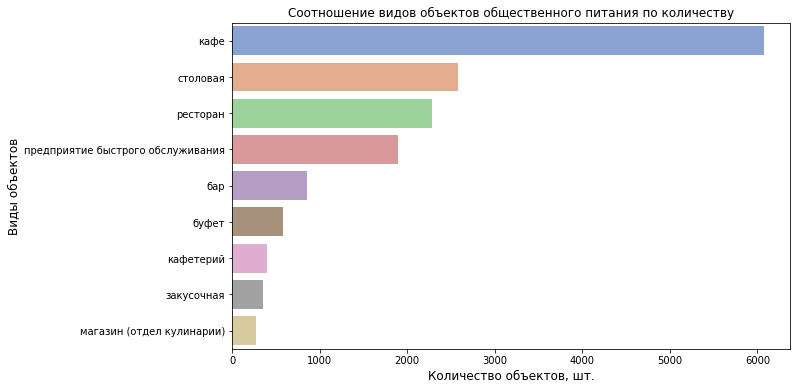

In [12]:
# визуализируем полученную таблицу столбчатой диаграммой
plt.figure(figsize=(10, 6))  
ax1 = sns.barplot(x='id', y='object_type', data=data_grouped_types, 
                  palette='muted', alpha=.7, order=data_grouped_types['object_type'])
ax1.set_title('Cоотношение видов объектов общественного питания по количеству')
ax1.set_xlabel('Количество объектов, шт.', size=12)
ax1.set_ylabel('Виды объектов', size=12)
plt.show()

В Москве большой перевес в сторону обычных кафе, больше чем столовых и ресторанов вместе взятых.

### Cоотношение сетевых и несетевых заведений по количеству
<a id="analysis_2"></a>

In [13]:
data_pivot_chain = data.pivot_table(index='object_type', 
                                    columns='chain',
                                    values='id', 
                                    aggfunc='count',
                                    margins=True).sort_values(0, ascending = False)
                                    
data_pivot_chain

chain                              False  True    All
object_type                                          
All                                12317  2964  15281
кафе                                4675  1396   6071
столовая                            2581     3   2584
ресторан                            1739   543   2282
предприятие быстрого обслуживания   1109   788   1897
бар                                  818    37    855
буфет                                565    11    576
кафетерий                            343    52    395
закусочная                           292    56    348
магазин (отдел кулинарии)            195    78    273

In [14]:
# визуализируем тоже самое группированной столбчатой гистограммой

fig = px.histogram(data, x='object_type', color='chain', 
                   color_discrete_sequence = ["rgb(166,206,227)",
                                              "rgb(251,154,153)"]).update_xaxes(categoryorder='total descending')

fig.update_layout(
    title_text='Cоотношение сетевых и несетевых заведений по количеству', # title of plot
    xaxis_title_text='Виды объектов', # x label
    yaxis_title_text='Количество объектов, шт.', # y label
    bargap=0.2, # gap between bars of adjacent location coordinates
    bargroupgap=0.1 # gap between bars of the same location coordinates
)
fig.show()

# ax2 = sns.catplot(
#     data=data, x='object_type', hue='chain', kind='count',
#     ci='sd', palette='muted', alpha=.8, height=8
# ).set(title='Cоотношение сетевых и несетевых заведений по количеству')
# ax2.set_axis_labels('Количество объектов, шт.', 'Виды объектов')
# plt.show()

In [15]:
print('Процент сетевых заведений от общего числа:', round(len(data.query('chain == True'))/len(data)*100, 2), '%')

Процент сетевых заведений от общего числа: 19.4 %


### Вывод по объектам питания с сетевым распространением
<a id="analysis_3"></a>

In [16]:
data_pivot_chain_percent = (data.pivot_table(index='object_type', 
                                             values='chain', 
                                             aggfunc='mean').
                            sort_values('chain', ascending = False).
                            round(3).
                            rename(columns = {'chain': '% сетевых'})
                           )
data_pivot_chain_percent

% сетевых
object_type                                 
предприятие быстрого обслуживания       0.41
магазин (отдел кулинарии)               0.29
ресторан                                0.24
кафе                                    0.23
закусочная                              0.16
кафетерий                               0.13
бар                                     0.04
буфет                                   0.02
столовая                                0.00

In [17]:
# дополнительная визуализация в %
fig = px.histogram(data, x='object_type', color='chain', barnorm='percent', 
                   color_discrete_sequence = ["rgb(166,206,227)",
                                              "rgb(251,154,153)"]).update_xaxes(categoryorder='max ascending')

fig.update_layout(
    title_text='Cоотношение сетевых и несетевых заведений в %', 
    xaxis_title_text='Виды объектов',
    yaxis_title_text='Количество объектов в %', 
    bargap=0.2, 
    bargroupgap=0.1 
)
fig.show()

В основном сетевыми бывают фастфуды (чуть больше 40%), далее идут отделы кулинарии в сетевых магазинах, рестораны и кафе. А вот столовых сетевых практически нет.

### Что характерно для сетевых заведений
<a id="analysis_4"></a>
Узнаем, что характерно для сетевых заведений, много заведений с небольшим числом посадочных мест в каждом или мало заведений с большим количеством посадочных мест?

In [18]:
# группируем объекты по названию сетей и считаем число заведений и среднее число посадочных мест
chain_true_places = (
    data.query('chain == True')
    .groupby('object_name', as_index=False)
    .agg({'id': 'count', 'number':'mean'})
    .sort_values(by = 'id', ascending = False)
    .round(2)
    .rename(columns = {'id': 'object_counts', 'number':'avg_places'})
)

display(chain_true_places)
chain_true_places.describe(include='all').T

# data_pivot_chain_true = (data.query('chain == True').
#                          pivot_table(index='object_name', values=['id','number'],
#                                      aggfunc={'id':'count','number':'mean'}).reset_index().
#                          round(2).
#                          rename(columns = {'id': 'число заведений', 'number':'мест в среднем'})
#                         )

object_name  object_counts  avg_places
536                            шоколадница            179       57.22
38                              mcDonald's            163       88.83
28                                     kfc            157       55.44
7                              burger king            142       46.39
15                          domino’s pizza             95       18.18
..                                     ...            ...         ...
98                                барбарис              1       25.00
291  кофейня кофемания, пиццерия бармалини              1       90.00
290                кофейня «старбакс кофе»              1       23.00
289                     кофейня «де марко»              1       40.00
0                      beverly hills diner              1       88.00

[550 rows x 3 columns]

count unique             top freq  mean   std  min   25%   50%  \
object_name      550    550  пицца экспресс    1   NaN   NaN  NaN   NaN   NaN   
object_counts 550.00    NaN             NaN  NaN  5.39 17.12 1.00  1.00  1.00   
avg_places    550.00    NaN             NaN  NaN 59.04 54.85 0.00 20.00 43.99   

                75%    max  
object_name     NaN    NaN  
object_counts  3.00 179.00  
avg_places    83.32 306.00

Добавляем категоризацию: разобъем все сети на 4 группы по признакам много/мало ресторанов, много/мало посадочных мест:

In [19]:
# функция для распределения объектов по категориям
def chain_group(row):
    if row['object_counts'] < 5 and row['avg_places'] < 45:
        return 'мало объектов и мест'
    if row['object_counts'] < 5 and row['avg_places'] >= 45:
        return 'мало объектов и много мест'
    if row['object_counts'] >= 5 and row['avg_places'] < 45:
        return 'много объектов и мало мест'
    return 'много объектов и мест'

# добавляем в таблицу столбец с категорией
chain_true_places['chain_group'] = chain_true_places.apply(chain_group, axis = 1)
chain_true_places['chain_group'].value_counts()

мало объектов и много мест    230
мало объектов и мест          224
много объектов и мало мест     53
много объектов и мест          43
Name: chain_group, dtype: int64

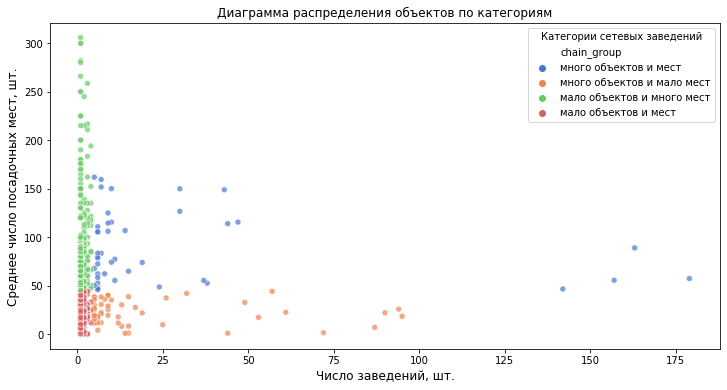

In [20]:
# строим точечную диаграмму
plt.figure(figsize=(12, 6))
ax2 = sns.scatterplot(data=chain_true_places, x='object_counts', y='avg_places', 
                      hue='chain_group', palette='muted', alpha=.7)
ax2.set_title('Диаграмма распределения объектов по категориям')
ax2.set_xlabel('Число заведений, шт.', size=12)
ax2.set_ylabel('Среднее число посадочных мест, шт.', size=12)
ax2.legend(title='Категории сетевых заведений')
plt.show()

На диаграмме видно, что самые многочисленные группы это сети, где мало заведений. Можно сделать вывод, что для сетевых заведений более характерно - мало заведений с большим количеством посадочных мест.

### Cреднее количество посадочных мест для каждого вида объекта питания
<a id="analysis_5"></a>

In [21]:
# группируем по типам объектов питания и выводим среднее число посадочных мест
data_grouped_places = (
    data.groupby('object_type', as_index=False)
    .agg({'number':'mean'})
    .sort_values(by = 'number', ascending = False)
    .round(2)
    .rename(columns = {'number':'avg_places'})
)

data_grouped_places

object_type  avg_places
8                           столовая      130.34
7                           ресторан       96.88
1                              буфет       51.43
0                                бар       43.53
3                               кафе       39.79
6  предприятие быстрого обслуживания       20.81
4                          кафетерий        9.18
2                         закусочная        7.85
5          магазин (отдел кулинарии)        5.59

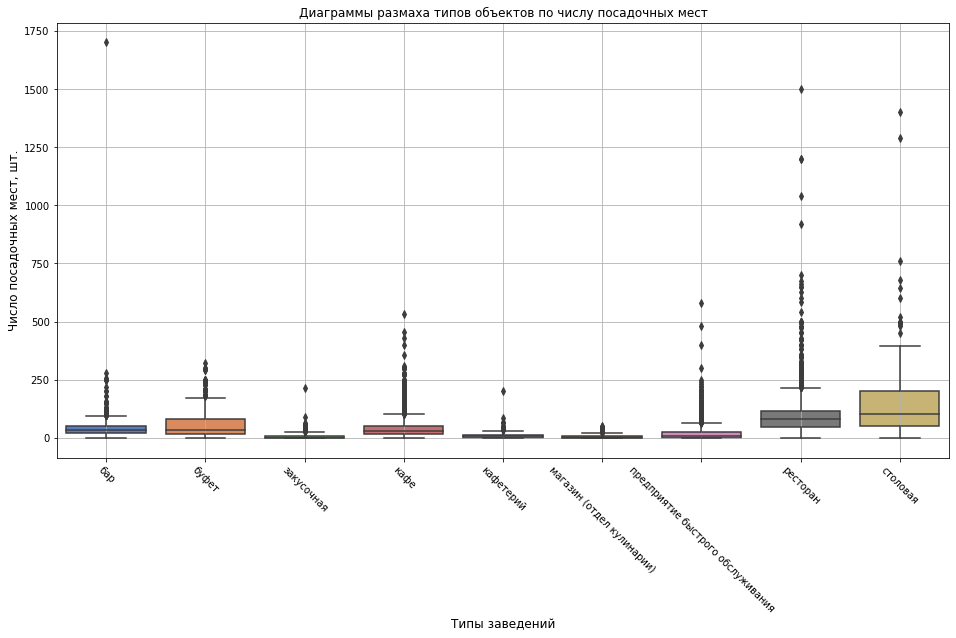

In [22]:
# строим диаграммы размаха для связки типа объекта и числа посадочных мест по исходной таблице
plt.figure(figsize=(16, 8))
ax3 = sns.boxplot(data = data , x='object_type', y='number', palette='muted')
ax3.set_xlabel('Типы заведений', size=12)
ax3.set_ylabel('Число посадочных мест, шт.', size=12)
ax3.set_title('Диаграммы размаха типов объектов по числу посадочных мест')
plt.xticks(rotation=315)
plt.grid()
plt.show()

Из-за большого количества выбивающихся значений графики сложно анализировать, но в целом заметно, что интервал до 500 мест был бы нагляднее.

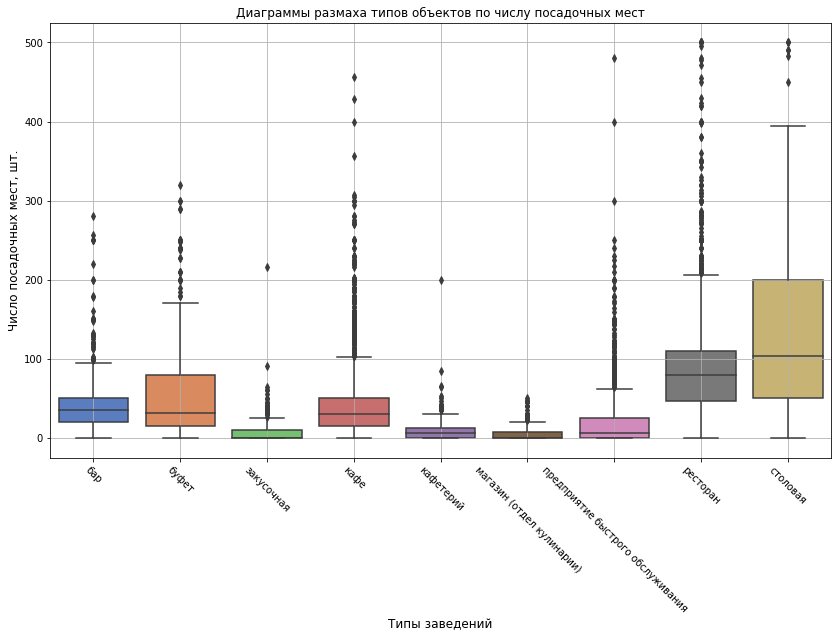

In [23]:
plt.figure(figsize=(14, 8))
ax4 = sns.boxplot(data = data.query('number <= 500'), x='object_type', y='number', palette='muted')
ax4.set_xlabel('Типы заведений', size=12)
ax4.set_ylabel('Число посадочных мест, шт.', size=12)
ax4.set_title('Диаграммы размаха типов объектов по числу посадочных мест')
plt.xticks(rotation=315)
plt.grid()
plt.show()

Столовые предоставляют в среднем самое большое количество посадочных мест, следом за ними располагаются рестораны. Это заметно и по средним значениям и по медианным. Остальные типы им прилично уступают.

### Выделение улицы у объектов
<a id="analysis_6"></a>
Выделим в отдельный столбец информацию об улице из столбца address.

In [24]:
# задаем регулярное выражение и ищем по словам маркерам
pattern = '\,(([а-яА-Я0-9\s-]+)?(улица|переулок|шоссе|проезд|проспект|набережная|бульвар|площадь)([а-яА-Я0-9\s-]+)?)\,'
#\, - кусок строки должен начинаться с запятой и заканчиваться запятой
#([а-яА-Я0-9\s-]+)? - опциональный (поэтому ?) кусок строки, содержащий кирилические заглавные и строчные буквы, 
# пробелы, тире и цифры
#(улица|переулок|шоссе) - слово "улица" или "переулок" или "шоссе" и т.д.
data['street'] = data['address'].str.extract(pat = pattern)[0]
data['street'] = data['street'].str.strip()
data['street'].value_counts().head(10)

# разделителем является запятая, выделяем 2-ой элемент в списке, убираем пробелы в конце строк, если они есть
#data['street'] = data['address'].str.split(',').str.get(1).str.strip()
# Видим, что данное решение не дает 100% результат получения именно улиц, но будем считать, 
# что другие муниципальные единицы (пригороды относящиеся к Москве) нам не так важны для анализа.

проспект Мира             203
Профсоюзная улица         181
Ленинградский проспект    170
Пресненская набережная    167
Варшавское шоссе          164
Ленинский проспект        147
проспект Вернадского      128
Кутузовский проспект      114
Каширское шоссе           111
Кировоградская улица      108
Name: street, dtype: int64

### Топ-10 улиц по количеству объектов общественного питания
<a id="analysis_7"></a>

In [25]:
# подгружаем данные, найденные в интернете с официального источника г.Москвы, о соответствии улиц районам:
spreadsheet_id = '10gg9OCgE_PAwPkDRrzB8zYMBHwEOXzG06JmeWjPDPxw'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)

r = requests.get(file_name)
mos_streets_district = pd.read_csv(BytesIO(r.content))
mos_streets_district['streetname'] = mos_streets_district['streetname'].str.strip()
mos_streets_district

streetname  areaid okrug               area
0                Выставочный переулок      17   ЦАО  Пресненский район
1                        улица Гашека      17   ЦАО  Пресненский район
2             Большая Никитская улица      17   ЦАО  Пресненский район
3                   Глубокий переулок      17   ЦАО  Пресненский район
4     Большой Гнездниковский переулок      17   ЦАО  Пресненский район
...                               ...     ...   ...                ...
4393              Вознесенский проезд      17   ЦАО  Пресненский район
4394                  Волков переулок      17   ЦАО  Пресненский район
4395                  Поварская улица      17   ЦАО  Пресненский район
4396               Кудринская площадь      17   ЦАО  Пресненский район
4397               Вспольный переулок      17   ЦАО  Пресненский район

[4398 rows x 4 columns]

In [26]:
# выделяем топ-10 улиц по количеству объектов питания в нашем файле:
top10_streets = (
    data[~data['street'].isin(('город Зеленоград', 'поселение Сосенское'))]
    .groupby('street', as_index=False)
    .agg({'id':'count'})
    .sort_values(by = 'id', ascending = False)
    .rename(columns = {'id':'objects_quantity'})
    .head(10)
)

top10_streets

street  objects_quantity
1315           проспект Мира               203
947        Профсоюзная улица               181
640   Ленинградский проспект               170
932   Пресненская набережная               167
366         Варшавское шоссе               164
643       Ленинский проспект               147
1311    проспект Вернадского               128
630     Кутузовский проспект               114
556          Каширское шоссе               111
562     Кировоградская улица               108

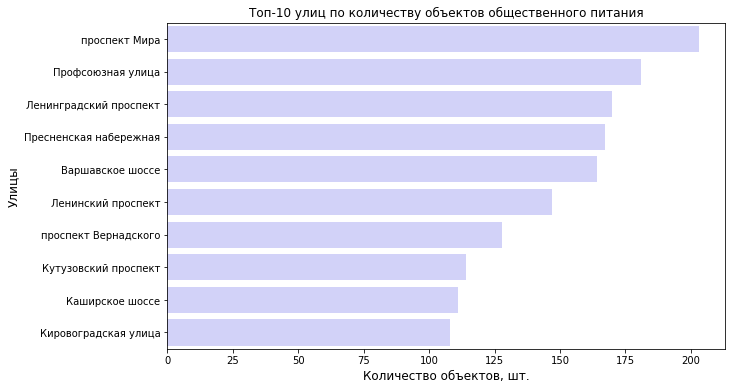

In [27]:
# визуализируем полученную таблицу столбчатой диаграммой
plt.figure(figsize=(10, 6))
ax5 = sns.barplot(x='objects_quantity', y='street', data=top10_streets, 
                  color='b', alpha=.2, order=top10_streets['street'])
ax5.set_title('Топ-10 улиц по количеству объектов общественного питания')
ax5.set_xlabel('Количество объектов, шт.', size=12)
ax5.set_ylabel('Улицы', size=12)
plt.show()

В этом списке много улиц, которые официально считаются самыми длинными в Москве, поэтому неудивительно, что они в топе по заведениям.

In [28]:
# объединяем полученные таблицы
top10_streets_district = (
    top10_streets.merge(
        mos_streets_district, left_on='street', right_on='streetname'
    ).drop(columns=['streetname', 'areaid'])
)
top10_streets_district

street  objects_quantity okrug  \
0            проспект Мира               203  СВАО   
1            проспект Мира               203  СВАО   
2            проспект Мира               203  СВАО   
3            проспект Мира               203  СВАО   
4            проспект Мира               203  СВАО   
5            проспект Мира               203  СВАО   
6            проспект Мира               203   ЦАО   
7        Профсоюзная улица               181  ЮЗАО   
8        Профсоюзная улица               181  ЮЗАО   
9        Профсоюзная улица               181  ЮЗАО   
10       Профсоюзная улица               181  ЮЗАО   
11       Профсоюзная улица               181  ЮЗАО   
12       Профсоюзная улица               181  ЮЗАО   
13  Ленинградский проспект               170   САО   
14  Ленинградский проспект               170   САО   
15  Ленинградский проспект               170   САО   
16  Ленинградский проспект               170   САО   
17  Пресненская набережная               167   ЦАО   
18        Варшавское шоссе               164   ЮАО   
19        Варшавское шоссе               164   ЮАО   
20        Варшавское шоссе               164   ЮАО   
21        Варшавское шоссе               164   ЮАО   
22        Варшавское шоссе               164   ЮАО   
23        Варшавское шоссе               164   ЮАО   
24        Варшавское шоссе               164  ЮЗАО   
25        Варшавское шоссе               164  ЮЗАО   
26      Ленинский проспект               147   ЗАО   
27      Ленинский проспект               147   ЗАО   
28      Ленинский проспект               147   ЮАО   
29      Ленинский проспект               147  ЮЗАО   
30      Ленинский проспект               147  ЮЗАО   
31      Ленинский проспект               147  ЮЗАО   
32      Ленинский проспект               147  ЮЗАО   
33      Ленинский проспект               147   ЦАО   
34    проспект Вернадского               128   ЗАО   
35    проспект Вернадского               128   ЗАО   
36    проспект Вернадского               128   ЗАО   
37    проспект Вернадского               128  ЮЗАО   
38    проспект Вернадского               128  ЮЗАО   
39    Кутузовский проспект               114   ЗАО   
40    Кутузовский проспект               114   ЗАО   
41         Каширское шоссе               111   ЮАО   
42         Каширское шоссе               111   ЮАО   
43         Каширское шоссе               111   ЮАО   
44         Каширское шоссе               111   ЮАО   
45    Кировоградская улица               108   ЮАО   
46    Кировоградская улица               108   ЮАО   
47    Кировоградская улица               108   ЮАО   

                               area  
0                Алексеевский район  
1                 Ярославский Район  
2                Район Марьина роща  
3                Останкинский район  
4                   Район Ростокино  
5                    Район Свиблово  
6                   Мещанский район  
7               Академический район  
8                   Район Черемушки  
9                     Район Ясенево  
10                   Район Коньково  
11                Обручевский район  
12                Район Теплый Стан  
13                   Район Аэропорт  
14                    Район Беговой  
15                Хорошевский район  
16                      Район Сокол  
17                Пресненский район  
18      Район Чертаново Центральное  
19         Район Чертаново Северное  
20            Район Чертаново Южное  
21                    Донской район  
22         Район Нагатино-Садовники  
23                   Нагорный район  
24            Район Северное Бутово  
25               Район Южное Бутово  
26       Район Проспект Вернадского  
27         Район Тропарево-Никулино  
28                    Донской район  
29                Район Гагаринский  
30              Ломоносовский район  
31                Обручевский район  
32                Район Теплый Стан  
33                   Район Якиманка  
34       Район Проспект Вернадского  
35   

In [29]:
top10_streets_district.groupby('area')['objects_quantity'].sum().sort_values(ascending = False)

area
Обручевский район                  328
Район Теплый Стан                  328
Донской район                      311
Район Гагаринский                  275
Район Проспект Вернадского         275
Ломоносовский район                275
Район Нагатино-Садовники           275
Район Тропарево-Никулино           275
Район Чертаново Южное              272
Район Чертаново Центральное        272
Район Чертаново Северное           272
Район Ростокино                    203
Район Свиблово                     203
Ярославский Район                  203
Останкинский район                 203
Мещанский район                    203
Алексеевский район                 203
Район Марьина роща                 203
Район Коньково                     181
Академический район                181
Район Ясенево                      181
Район Черемушки                    181
Хорошевский район                  170
Район Беговой                      170
Район Аэропорт                     170
Район Сокол         

Каждая улица пересекает несколько районов. Есть улицы которые пересекают одни и те же районы (набор районов), поэтому районы-лидеры по количеству точек питания условные, нельзя назвать точных цифр, так как распределение объектов по улице может быть неравномерным.

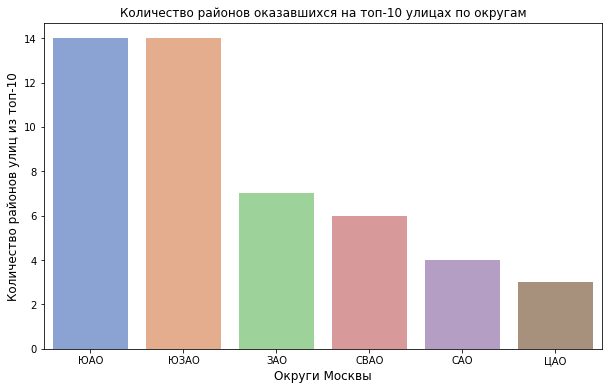

In [30]:
# визуализируем количество районов оказавшихся на топ-10 улицах по округам
top10_streets_okrug = (
    top10_streets_district.groupby('okrug', as_index=False)['area'].count()
    .sort_values(by='area', ascending = False)
)
plt.figure(figsize=(10, 6))
ax6 = sns.barplot(x='okrug', y='area', data=top10_streets_okrug, 
                  palette='muted', alpha=.7)
ax6.set_title('Количество районов оказавшихся на топ-10 улицах по округам')
ax6.set_xlabel('Округи Москвы', size=12)
ax6.set_ylabel('Количество районов улиц из топ-10', size=12)
plt.show()

В абсолютных лидерах ЮАО и ЮЗАО. Видимо, там находится большинство улиц с наибольшим количеством заведений питания.

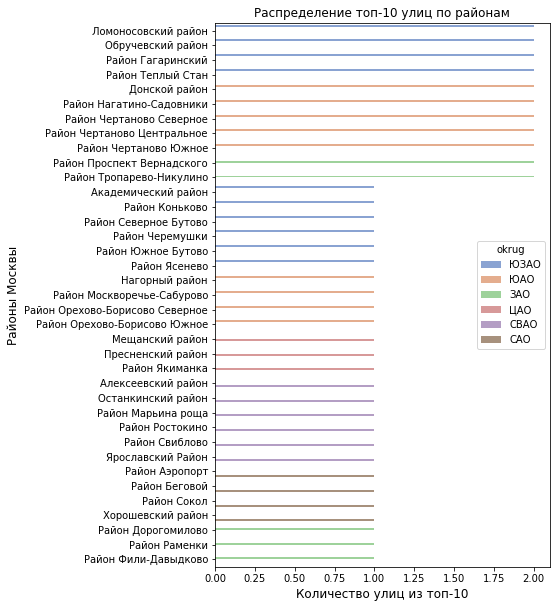

In [31]:
# посмотрим какие это районы
plt.figure(figsize=(6, 10))
ax7 = sns.barplot(x='street', y='area', data=top10_streets_district.groupby(['area', 'okrug'], as_index=False)['street'].count()
                  .sort_values(by=['street','okrug'], ascending = False), 
                  palette='muted', alpha=.7, hue='okrug')
ax7.set_title('Распределение топ-10 улиц по районам')
ax7.set_xlabel('Количество улиц из топ-10', size=12)
ax7.set_ylabel('Районы Москвы', size=12)
plt.show()

### Улицы с одним объектом общественного питания
<a id="analysis_8"></a>
Найдем число улиц с одним объектом общественного питания.

In [32]:
# выделяем и считаем улицы с 1 объектом питания:
object1_streets = (
    data.groupby('street', as_index=False)
    .agg({'id':'count'})
    .query('id == 1')
    .rename(columns = {'id':'objects_quantity'})
)

print('Улиц в Москве с одним объектом питания:',len(object1_streets))

Улиц в Москве с одним объектом питания: 510


In [33]:
# получаем таблицу улиц с 1 объектом питания с районами
object1_streets_district = (
    object1_streets.merge(
        mos_streets_district, left_on='street', right_on='streetname'
    ).drop(columns=['streetname', 'areaid'])
)
object1_streets_district

street  objects_quantity okrug                     area
0    1-й Балтийский переулок                 1   САО           Район Аэропорт
1     1-й Басманный переулок                 1   ЦАО          Басманный район
2     1-й Басманный переулок                 1   ЦАО     Красносельский район
3    1-й Ботанический проезд                 1  СВАО           Район Свиблово
4    1-й Вешняковский проезд                 1  ЮВАО          Рязанский район
..                       ...               ...   ...                      ...
521           улица Шеногина                 1  СЗАО  Район Хорошево-Мневники
522           улица Шумилова                 1  ЮВАО          Район Кузьминки
523            улица Шумкина                 1   ВАО         Район Сокольники
524              улица Щорса                 1   ЗАО           Район Солнцево
525             шоссе Фрезер                 1  ЮВАО      Нижегородский район

[526 rows x 4 columns]

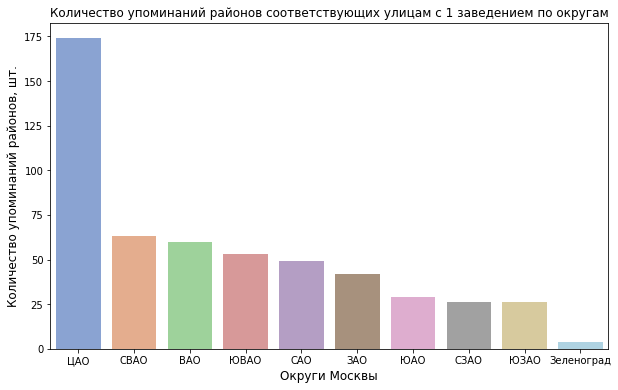

In [34]:
# визуализируем количество районов оказавшихся на улицах c 1 заведением по округам
object1_streets_okrug = (
    object1_streets_district.groupby('okrug', as_index=False)['area'].count()
    .sort_values(by='area', ascending = False)
)
plt.figure(figsize=(10, 6))
ax8 = sns.barplot(x='okrug', y='area', data=object1_streets_okrug, 
                  palette='muted', alpha=.7)
ax8.set_title('Количество упоминаний районов соответствующих улицам с 1 заведением по округам')
ax8.set_xlabel('Округи Москвы', size=12)
ax8.set_ylabel('Количество упоминаний районов, шт.', size=12)
plt.show()

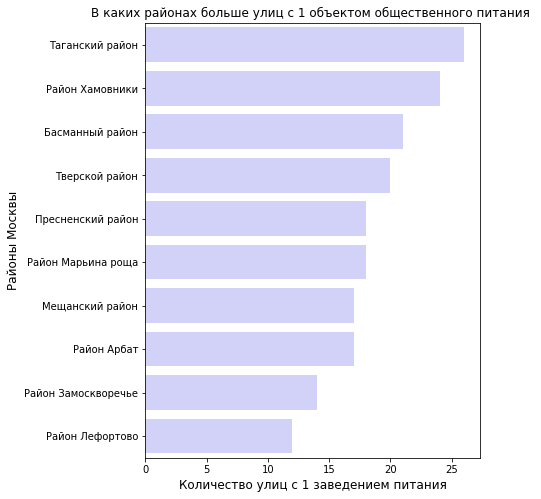

In [35]:
# посмотрим какие это районы (топ-10)
plt.figure(figsize=(6, 8))
ax9 = sns.barplot(x='street', y='area', data=object1_streets_district.groupby(['area', 'okrug'], as_index=False)['street']
                  .count()
                  .sort_values(by=['street','okrug'], ascending = False).head(10), 
                  alpha=.2, color='b')
ax9.set_title('В каких районах больше улиц с 1 объектом общественного питания ')
ax9.set_xlabel('Количество улиц с 1 заведением питания', size=12)
ax9.set_ylabel('Районы Москвы', size=12)
plt.show()

В основном такие улицы расположены в ЦАО, это можно объяснить тем, что там много совсем небольших улиц.

### Распределение количества посадочных мест для улиц с большим количеством объектов 
<a id="analysis_9"></a>

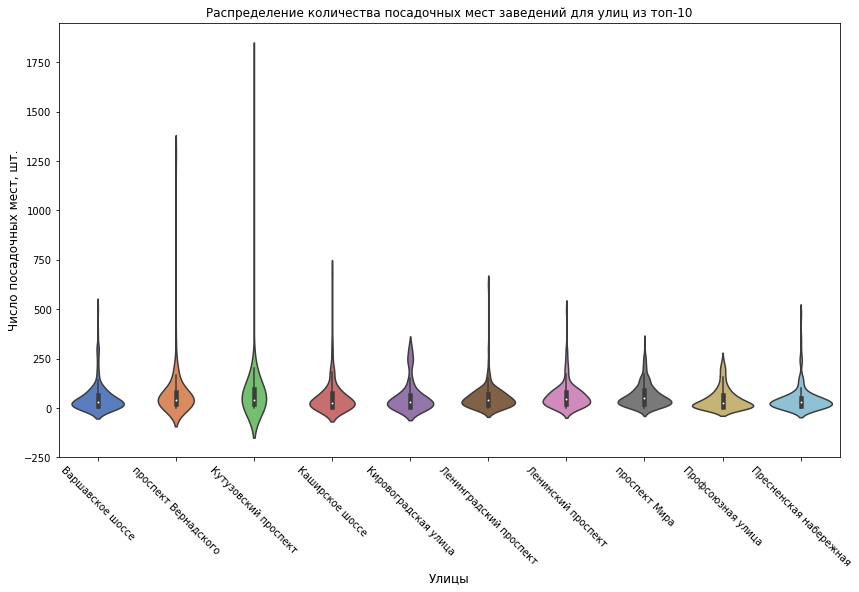

In [36]:
# делаем срез по объектам на топ-10 улицах
top10_streets_data = data[data['street'].isin(top10_streets['street'])]

# строим графики-скрипки для изучения распределений
plt.figure(figsize=(14, 8))
ax10 = sns.violinplot(x='street', y='number', data=top10_streets_data, palette='muted', alpha=.5)
plt.xticks(rotation=315)
ax10.set_title('Распределение количества посадочных мест заведений для улиц из топ-10')
ax10.set_xlabel('Улицы', size=12)
ax10.set_ylabel('Число посадочных мест, шт.', size=12)
plt.show()

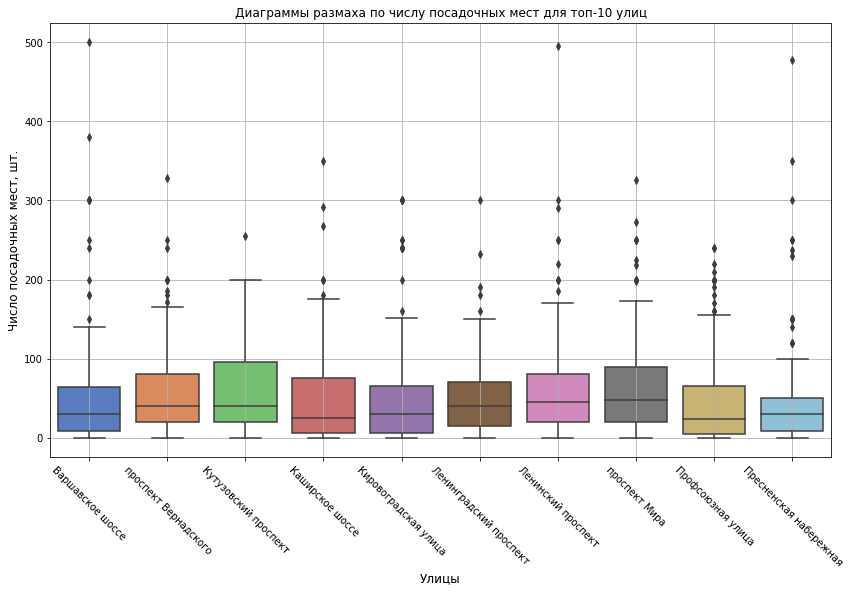

In [37]:
plt.figure(figsize=(14, 8))
ax4 = sns.boxplot(x='street', y='number', data=top10_streets_data.query('number <= 500'), palette='muted')
ax4.set_xlabel('Улицы', size=12)
ax4.set_ylabel('Число посадочных мест, шт.', size=12)
ax4.set_title('Диаграммы размаха по числу посадочных мест для топ-10 улиц')
plt.xticks(rotation=315)
plt.grid()
plt.show()

В целом можно сказать, что в среднем для заведений на улицах с большим количеством объектов питания характерно не очень большое число посадочных мест (в диапазоне 25-50) и равномерная плотность распределния со скошенностью вправо. Почти по всем улицам основная масса числа посадочных мест концентрируется у медианного центра. Наибольший разброс числа мест в заведениях на Кутузовском проспекте («размазываются» по широкому диапазону).

## Общий вывод и рекомендации
<a id="conclusion"></a>
Данные для анализа потребовали порядочной предобработки. В результате нее были обработаны неявные дубликаты и синонимы по объектам.

Было проведено исследование по объектам общественного питания в городе Москва.
Выводы по исследованию:
1. Самый популярный вид объектов - это кафе. Их более 6000 тысяч. Также достаточно много столовых, ресторанов и фастфудов.
2. Процент сетевых заведений от общего числа заведений составляет чуть меньше 20%.
3. В основном сетевыми являются фастфуды (чуть больше 40% от общего числа фастфудов), далее идут отделы кулинарии в сетевых магазинах, рестораны и кафе (в диапазоне 29-23%).
4. Для сетевых заведений более характерно малое число заведений с большим количеством посадочных мест.
5. Столовые предоставляют в среднем самое большое количество посадочных мест (130), следом за ними располагаются рестораны (около 100). Остальные типы им прилично уступают.
6. Нашли топ-10 улиц по количеству точек общественного питания, больше всего их в ЮАО И ЮЗАО. А если брать районы, то это будут - Ломоносовский, Обручевский, Гагаринский, Теплый стан, Донской, Нагатино-Садовники, проспекта Вернадского, Тропарево-Никулино и все районы Чертаново. В целом, в топ-10 вошло много длинных улиц Москвы, что логично. Также стоит отметить, что количество населения в ЮАО и ЮЗАО находится в топе по Москве, что требует большого количества мест общественного питания.
7. Сделали анализ улиц в привязке к районам, где чаще встречается 1 заведение питания на улицу. Тут победил ЦАО с большим отрывом. Таганский район на первом месте (27 таких улиц). Вероятно, в центре много мелких улиц, переулков и т.д. Плюс стоимость аренды помещений высока.
8. Для заведений на улицах с большим количеством объектов питания характерно не очень большое число посадочных мест (в диапазоне 25-50), можно заметить, что среднее число посадочных мест больше именно на проспектах (ближе к 50).

Рекомендации:
1. По виду заведения, предлагается выбирать между кафе и рестораном, это зависит в том числе от направления кухни и ее разнообразия. Заведение претендует на уникальность, это должно вызвать ажиотаж даже при не самом демократическом ценнике. Демократичным заведениям тяжело выходить на безубыточность.
2. По количеству посадочных мест - минимум от 45 в случае кафе и около 100 для ресторана. Количество мест влияет на выручку, а ее нужно увеличивать, чтобы скорее окупились вложения.
3. По району расположения - стартапу лучше не заходить сразу в центр, там находятся сильные сетевые заведения, учитывая что аренда — одна из самых больших затрат. Лучше начать с улиц с большой проходимостью за Садовым кольцом. Можно открыть точку на проспекте Мира, Ленинском или Ленинградском (подходящие помещения там найдутся). Или наоборот присмотреться к районам Сокольники или Марьина Роща, там должно быть мало конкурентов поблизости и аренда пониже чем в центральных районах. 
4. Развитие сети вполне возможно, если грамотно стартовать и выйти на окупаемость. В дальнейшем можно будет присмотреться и к центральным районам, так как там обеспечена большая проходимость и платежеспособность посетителей.

## Презентация по исследованию
<a id="preza"></a>
Презентация: https://disk.yandex.ru/i/xPlISeAej6Z23A